# Stochastic, Mini Batch e Full Batch Gradient Descend
In questo notebook eseguiremo una classificazione utilizzando Full Batch Gradient Descend, Stochastic Gradient Descend e Mini Batch Gradient Descend al fine di confrontare le oscillazioni della funzione di costo per ognuno di essi.<br>
Importiamo le librerie necessarie

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import log_loss

Ed utilizziamo la funzione *make_classification* di scikit-learn per creare un dataset ad-hoc in cui poter eseguire la nostra classificazione

In [2]:
X, Y = make_classification(n_samples=1250, n_features=4, n_informative=2, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

## Stochastic Gradient Descend

Lo Stochastic Gradient Descend (SGD) è una versione del Gradient Descend che utilizza un solo esempio di addestramento per volta durante l'ottimizzazione.
<br><br>
Possiamo utilizzare la classe <span style="font-family: Monaco">SGDClassifier</span> di scikit-learn, di default questa utilizza lo SGD per addestrare una SVM, ma possiamo modificare la tipologia di modello semplicemente cambiando la funzione di costo:

 * **hinge**: l'SGD addestrerà una SVM
 * **log**: l'SGD addestrerà una regressione logistica
 * **perceptron:** l'SGD addestrerà un percettrone
 
Per evitare cicli bisogna mischiare il train set ad ogni epoca, per farlo basta impostare il parametro <span style="font-family: Monaco">shuffle</span>
 a True (questo valore è settato di default, quindi è possibile anche ometterlo)
 <br><br>
**NOTA BENE** Lo Stochastic Gradient Descend è un processo stocastico (ma vah), anche utilizzando gli stessi iperparametri un modello fornirà risultati lievemente differenti se riaddestrato.

In [3]:
%%time
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", verbose=False, shuffle=True) #verbose ci mostrerà informazioni sull'avanzamento dell'addestramento<
sgd.fit(X_train,Y_train)
print("LOSS: %.4f" % (log_loss(Y_test, sgd.predict_proba(X_test))))

LOSS: 0.5539
CPU times: user 83 ms, sys: 4.82 ms, total: 87.8 ms
Wall time: 85.9 ms


/Users/giuseppe/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


La classe SGDClassifier ci mette a disposizione il metodo <span style="font-family: Monaco">partial_fit</span>, che ci permette di eseguire l'addestramento su una parte di dati definita da noi.<br>
Utilizziamo <span style="font-family: Monaco">partial_fit</span> per eseguire lo **stochastic gradient descend** e raccogliamo il valore della funzione di costo ad ogni iterazione.<br>
**NOTA BENE** se utilizziamo <span style="font-family: Monaco">partial_fit</span> dobbiamo mischiare i dati manualmente ad ogni epoca, per farlo possiamo utilizzare il metodo <span style="font-family: Monaco">shuffle</span> di scikit-learn.

In [5]:
%%time

from sklearn.utils import shuffle

epochs = 5

n_batches=X_train.shape[0]
batch_size = X_train.shape[0]/n_batches

classes = np.unique(Y_train)

sgd = SGDClassifier(loss="log")
sgd_losses = []

for epoch in range(epochs):
        X_shuffled, Y_shuffled = shuffle(X_train, Y_train)
        for batch in range(n_batches):
            batch_start = int(batch*batch_size)
            batch_end = int((batch+1)*batch_size)
            X_batch = X_shuffled[batch_start:batch_end,:]
            Y_batch = Y_shuffled[batch_start:batch_end]

            sgd.partial_fit(X_batch, Y_batch, classes=classes)
            loss = log_loss(Y_test, sgd.predict_proba(X_test),labels=classes)
            sgd_losses.append(loss)       
        print("Loss all'epoca %d = %.4f" % (epoch+1, loss))

/Users/giuseppe/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Loss all'epoca 1 = 0.9615
Loss all'epoca 2 = 0.6928
Loss all'epoca 3 = 0.3313
Loss all'epoca 4 = 0.2291
Loss all'epoca 5 = 0.4946
CPU times: user 3.74 s, sys: 19.4 ms, total: 3.76 s
Wall time: 3.76 s


I risultati non sono buoni perché il numero di epoche definito non è sufficente per far convergere il gradient descend e quindi per trovare i coefficenti ottimali del modello.
<br><br>
Visualizzaziamo il grafico della funzione di costo ad ogni iterazione.

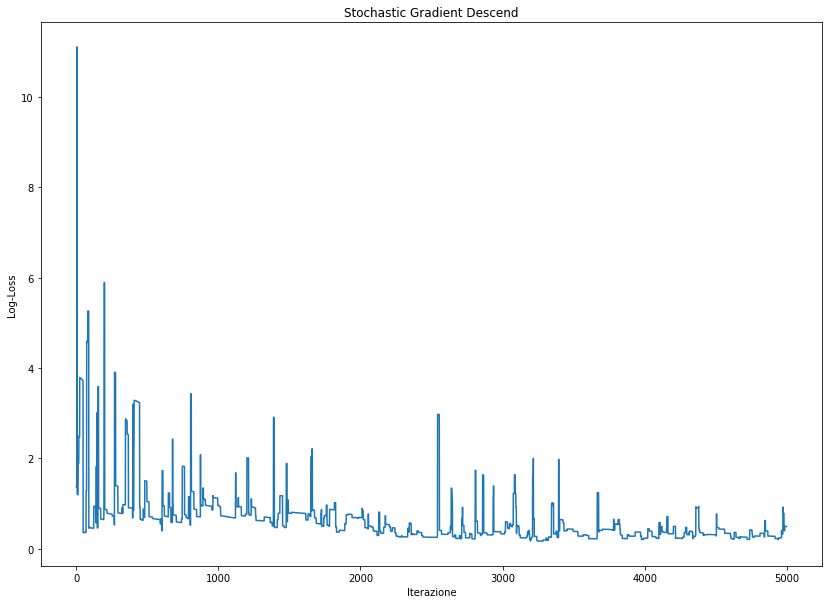

In [6]:
plt.figure(figsize=(14,10))
plt.title("Stochastic Gradient Descend")
plt.xlabel("Iterazione")
plt.ylabel("Log-Loss")
plt.plot(sgd_losses)

Il graico della funzione di costo per iterazione presenta un notevole rumore.

## Full Batch Gradient Descend
Adesso eseguiamo un Full Batch Gradient Descend sempre servendoci della funzione <span style="font-family: Monaco">partial_fit</span>, per farlo è sufficente passare l'intero train set ad ogni iterazione.

In [7]:
%%time

epochs = 200

n_batches=1

batch_size = X_train.shape[0]/n_batches

classes = np.unique(Y)

sgd = SGDClassifier(loss="log")
full_losses = []

for epoch in range(epochs):
        loss = 0.
        X_shuffled, Y_shuffled = shuffle(X_train, Y_train)
        for batch in range(n_batches):
            batch_start = int(batch*batch_size)
            batch_end = int((batch+1)*batch_size)
            X_batch = X_shuffled[batch_start:batch_end,:]
            Y_batch = Y_shuffled[batch_start:batch_end]

            sgd.partial_fit(X_batch, Y_batch, classes=classes)
            loss = log_loss(Y_test, sgd.predict_proba(X_test),labels=classes)
            full_losses.append(loss)       
        print("Loss all'epoca %d = %.4f" % (epoch+1, loss))

/Users/giuseppe/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Loss all'epoca 1 = 0.9539
Loss all'epoca 2 = 0.5407
Loss all'epoca 3 = 0.2848
Loss all'epoca 4 = 0.2438
Loss all'epoca 5 = 0.3109
Loss all'epoca 6 = 0.1800
Loss all'epoca 7 = 0.1930
Loss all'epoca 8 = 0.1846
Loss all'epoca 9 = 0.1423
Loss all'epoca 10 = 0.1221
Loss all'epoca 11 = 0.1509
Loss all'epoca 12 = 0.1272
Loss all'epoca 13 = 0.1653
Loss all'epoca 14 = 0.1709
Loss all'epoca 15 = 0.1168
Loss all'epoca 16 = 0.1537
Loss all'epoca 17 = 0.1267
Loss all'epoca 18 = 0.1260
Loss all'epoca 19 = 0.1152
Loss all'epoca 20 = 0.1176
Loss all'epoca 21 = 0.1163
Loss all'epoca 22 = 0.1249
Loss all'epoca 23 = 0.1318
Loss all'epoca 24 = 0.1218
Loss all'epoca 25 = 0.1151
Loss all'epoca 26 = 0.1113
Loss all'epoca 27 = 0.1492
Loss all'epoca 28 = 0.1143
Loss all'epoca 29 = 0.1164
Loss all'epoca 30 = 0.1076
Loss all'epoca 31 = 0.1126
Loss all'epoca 32 = 0.1206
Loss all'epoca 33 = 0.1157
Loss all'epoca 34 = 0.1112
Loss all'epoca 35 = 0.1321
Loss all'epoca 36 = 0.1085
Loss all'epoca 37 = 0.1088
Loss all'e

Il GD è riuscito a convergere fornendo un buon risultato, vediamo il grafico della funzione di costo ad ogni iterazione ( in questo caso un iterazione corrisponde ad un'epoca )

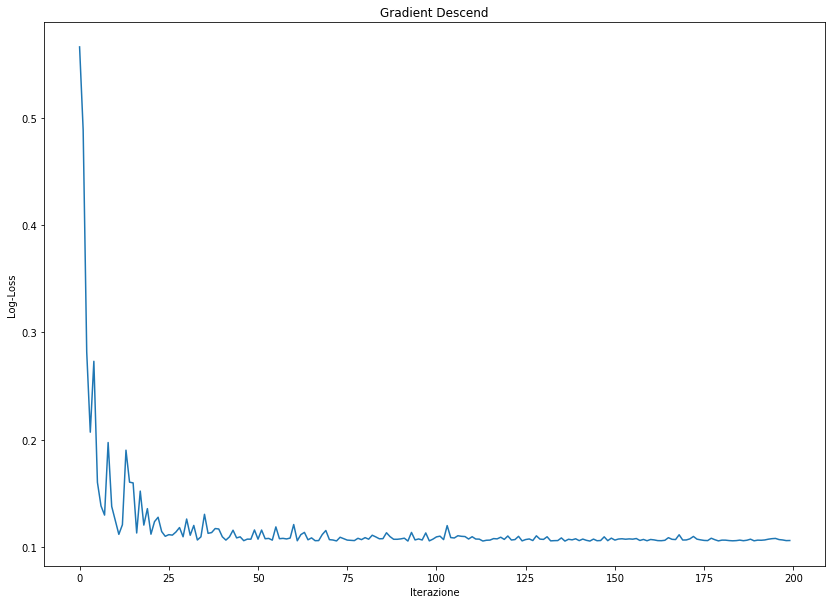

In [147]:
plt.figure(figsize=(14,10))
plt.title("Gradient Descend")
plt.xlabel("Iterazione")
plt.ylabel("Log-Loss")
plt.plot(full_losses)

La variazione della funzione di costo è molto più regolare rispetto allo SGD.

## Mini Batch Gradient Descend
Adess eseguiamo un Mini Batch Gradient Descend con 10 batches, quindi, considerando che nel train set ci sono 1000 esempi, eseguiremo il Gradient Descend uilizzando 100 esempi per volta.

In [9]:
%%time

epochs = 50

n_batches=10

batch_size = X_train.shape[0]/n_batches

classes = np.unique(Y)

sgd = SGDClassifier(loss="log")
batch_losses = []

for epoch in range(epochs):
        X_shuffled, Y_shuffled = shuffle(X_train, Y_train)
        for batch in range(n_batches):
            batch_start = int(batch*batch_size)
            batch_end = int((batch+1)*batch_size)
            X_batch = X_shuffled[batch_start:batch_end,:]
            Y_batch = Y_shuffled[batch_start:batch_end]
            print(X_batch.shape)
            sgd.partial_fit(X_batch, Y_batch, classes=classes)
            loss = log_loss(Y_test, sgd.predict_proba(X_test),labels=classes)
            batch_losses.append(loss)       
        print("Loss all'epoca %d = %.4f" % (epoch+1, loss))

(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 1 = 0.9087
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 2 = 0.3134
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 3 = 0.2415
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 4 = 0.2610
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 5 = 0.4035
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 6 = 0.1728
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 7 = 0.2369
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 8 = 0.2023
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)


/Users/giuseppe/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 15 = 0.1597
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 16 = 0.1258
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 17 = 0.1390
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 18 = 0.1091
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 19 = 0.1075
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 20 = 0.1312
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 21 = 0.1259
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 22 = 0.1122
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(

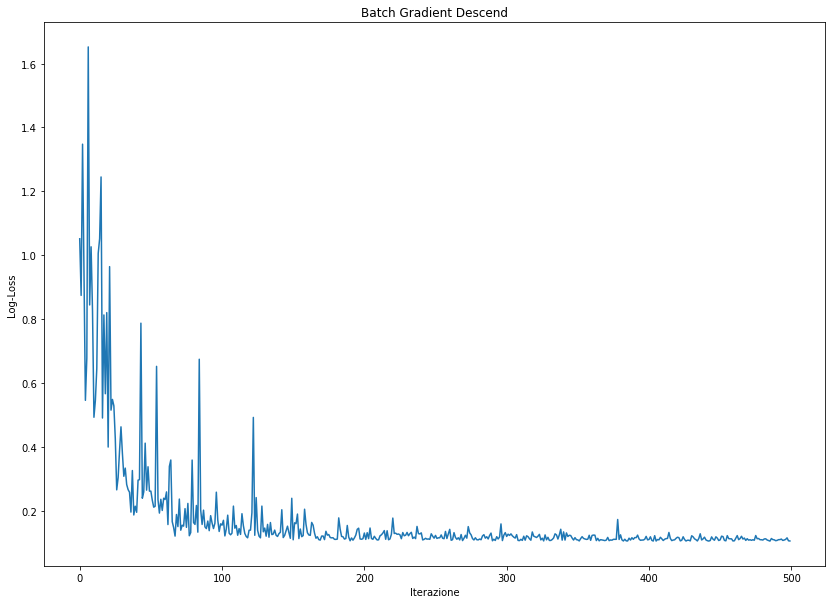

In [9]:
plt.figure(figsize=(14,10))
plt.title("Batch Gradient Descend")
plt.xlabel("Iterazione")
plt.ylabel("Log-Loss")
plt.plot(batch_losses)

## Il confronto
Confrontiamo le oscillazioni della funzione di costo per Full Batch, Stochastic e Mini Batch Gradient Descend, mettendole su di uno stesso grafico

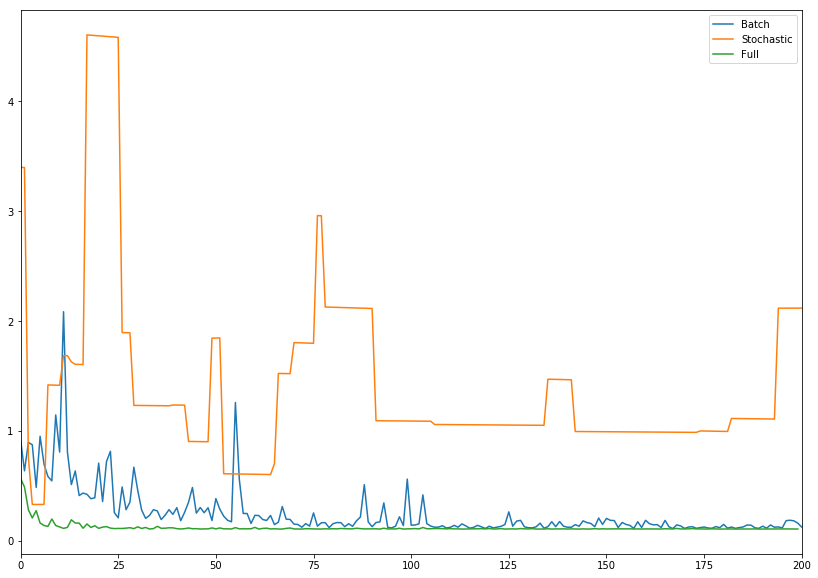

In [150]:
%matplotlib inline
plt.figure(figsize=(14,10))
plt.plot(batch_losses, label="Batch")
plt.plot(sgd_losses, label="Stochastic")
plt.plot(full_losses,label="Full")
plt.xlim(xmin=0,xmax=200)
plt.legend()
plt.show()